In [27]:
from __future__ import division
from ps4_utils import load_data,load_experiment
from ps4_utils import AbstractGenerativeModel
from ps4_utils import save_submission
from scipy.special import logsumexp
import numpy as np
data_fn = "datasets-ps4.h5"
MAX_OUTER_ITER = 15

In [28]:
class MixtureModel(AbstractGenerativeModel):
    def __init__(self, CLASSES, NUM_FEATURES, NUM_MIXTURE_COMPONENTS, MAX_ITER=50, EPS=10**(-7)):
        AbstractGenerativeModel.__init__(self, CLASSES, NUM_FEATURES)
        self.num_mixture_components = NUM_MIXTURE_COMPONENTS # list of num_mixture_components (length num_classes)
        self.max_iter = MAX_ITER # max iterations of EM
        self.epsilon = EPS # help with stability, to be used according to hint given at end of pset4.pdf
        self.params = { # lists of length CLASSES
            'pi': [np.repeat(1/k,k) for k in self.num_mixture_components], # with pi_c for each class
            'theta': [np.zeros((self.num_features,k)) for k in self.num_mixture_components], # with theta_c for each class
        }
    def pack_params(self, X, class_idx):
        pi,theta = self.fit(X[class_idx],class_idx) # fit parameters
        self.params['pi'][class_idx] = pi # update member variable pi
        self.params['theta'][class_idx] = theta #update member variable theta
        
    #make classification based on which mixture model gives higher probability to generating point xi
    def classify(self, X):
        P = list()
        pi = self.params['pi']
        theta = self.params['theta']
        for c in range(self.num_classes):
            _,Pc = self.findP(X, pi[c], theta[c])
            P.append(Pc)
        return np.vstack(P).T.argmax(-1) # np.array of class predictions for each data point in X

    # --- E-step
    def updateLatentPosterior(self, X, pi, theta, num_mixture_components): # update the latent posterior
        # YOUR CODE HERE
        # --- gamma: responsibilities (probabilities), np.array (matrix)
        # ---        shape: number of data points in X (where X consists of datapoints from class c) by NUM_MIXTURE_COMPONENTS[c]
        # note: can use output of findP here (with care taken to return gamma containing proper probabilities)

        gamma = np.zeros((X.shape[0], num_mixture_components))
        for i in range(X.shape[0]):
            likelihoods = np.zeros(num_mixture_components)
            for j in range(num_mixture_components):
                likelihoods[j] = np.exp(-0.5 * np.sum((X[i] - theta[:, j]) ** 2))
            unnormalized_posterior = pi * likelihoods
            gamma[i] = unnormalized_posterior / np.sum(unnormalized_posterior)

        return gamma
    
    # --- M-step (1)
    @staticmethod
    def updatePi(gamma): #update the pi component using the posteriors (gammas)
        # YOUR CODE HERE
        # --- pi_c: class specific pi, np.array (vector)
        # ---        shape: NUM_MIXTURE_COMPONENTS[c]

        pi_c = np.mean(gamma, axis=0)

        return pi_c
    
    # -- M-step (2)
    @staticmethod
    def updateTheta(X, gamma): #update theta component using posteriors (gammas)
        # YOUR CODE HERE
        # --- theta_c: class specific theta, np.array matrix
        # ---        shape: NUM_FEATURES by NUM_MIXTURE_COMPONENTS[c]

        theta_c = np.dot(X.T, gamma) / np.sum(gamma, axis=0, keepdims=True)

        return theta_c
    
    @staticmethod
    def findP(X, pi, theta):
        # YOUR CODE HERE
        # NOTE: you can also use t as a probability, just change "logsumexp(t,axis=1)" to "logsumexp(np.log(t),axis=1)"
        # --- t: logprobabilities of x given each component of mixture
        # ---        shape: number of data points in X (where X consists of datapoints from class c) by NUM_MIXTURE_COMPONENTS[c] 
        # --- logsumexp(t,axis=1): (for convenience) once exponentiated, gives normalization factor over all mixture components
        # ---        shape: number of data points in X (where X consists of datapoints from class c)

        epsilon = 10**(-7)
        t = np.zeros((X.shape[0], len(pi)))
        for c in range(len(pi)):
            log_probs = np.dot(X, np.log(theta[:, c] + epsilon)) + np.dot(1 - X, np.log(1 - theta[:, c] + epsilon))
            log_probs += np.log(pi[c])
            t[:, c] = log_probs

        return t, logsumexp(t,axis=1)
        
    # --- execute EM procedure
    def fit(self, X, class_idx):
        max_iter = self.max_iter
        eps = self.epsilon
        N = X.shape[0]
        pi = self.params['pi'][class_idx]
        theta = self.params['theta'][class_idx]
        num_mixture_components = self.num_mixture_components[class_idx]
        # INITIALIZE theta, note theta is currently set to zeros but needs to be officially initialized here

        theta = np.random.rand(self.num_features, num_mixture_components)

        for i in range(max_iter):
            # YOUR CODE HERE, E-step: gamma = self.updateLatentPosterior
            # YOUR CODE HERE, M-step(1): pi = self.updatePi 
            # YOUR CODE HERE, M-step(2): theta = self.updateTheta

            gamma = self.updateLatentPosterior(X, pi, theta, num_mixture_components)
            pi = self.updatePi(gamma)
            theta = self.updateTheta(X, gamma)
            
        return pi,theta #pi and theta, given class_idx

In [29]:
class NaiveBayesModel(AbstractGenerativeModel):
    def __init__(self, CLASSES, NUM_FEATURES, EPS=10**(-12)):
        AbstractGenerativeModel.__init__(self, CLASSES, NUM_FEATURES)
        self.epsilon = EPS # help with stability
        self.params = {
            'p': [np.zeros((NUM_FEATURES))] * self.num_classes # estimated log-probabilities of features for each class
        }
    
    def pack_params(self, X, class_idx):
        p = self.fit(X[class_idx])
        self.params['p'][class_idx] = p
    
    def classify(self, X): # naive bayes classifier
        # YOUR CODE HERE
        # --- predictions: predictions for data points in X (where X consists of datapoints from class c), np.array (vector)
        # ---        shape: number of data points

        predictions = np.empty(len(X), dtype=int)
        for i, sample in enumerate(X):
            likelihoods = []
            for c in range(self.num_classes):
                log_likelihood = np.sum(sample * np.log(self.params['p'][c] + self.epsilon) 
                + (1 - sample) * np.log(1 - self.params['p'][c] + self.epsilon))
                likelihoods.append(log_likelihood)
            predicted_class = np.argmax(likelihoods)
            predictions[i] = predicted_class
        
        return predictions

    def fit(self, X):
        # YOUR CODE HERE
        # --- estimated_p: estimated p's of features for input X (where X consists of datapoints from class c), np.array (vector)
        # ---        shape: NUM_FEATURES

        counts = np.sum(X, axis=0)
        total_samples = X.shape[0]
        num_features = X.shape[1]
        estimated_p = (counts + self.epsilon) / (total_samples + num_features * self.epsilon)

        return estimated_p

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

SENTIMENT ANALYSIS -- NAIVE BAYES MODEL:
ACCURACY ON VALIDATION: 0.74


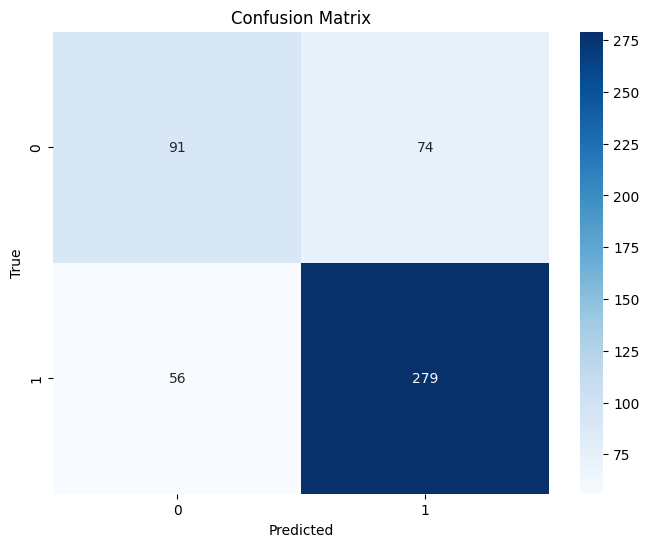

SENTIMENT ANALYSIS -- MIXTURE MODEL:
COMPONENTS: 12 4
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 14 4
ACCURACY ON VALIDATION: 0.748
COMPONENTS: 6 11
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 11 5
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 13 6
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 8 11
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 14 9
ACCURACY ON VALIDATION: 0.748
COMPONENTS: 6 9
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 11 14
ACCURACY ON VALIDATION: 0.748
COMPONENTS: 8 10
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 3 3
ACCURACY ON VALIDATION: 0.748
COMPONENTS: 4 14
ACCURACY ON VALIDATION: 0.748
COMPONENTS: 11 8
ACCURACY ON VALIDATION: 0.748
COMPONENTS: 5 6
ACCURACY ON VALIDATION: 0.746
COMPONENTS: 8 14
ACCURACY ON VALIDATION: 0.738
Saved: mm-sentiment_analysis-submission.csv


In [34]:
experiment_name = "sentiment_analysis"
# --- SENTIMENT ANALYSIS setup
Xtrain,Xval,num_classes,num_features = load_experiment(data_fn, experiment_name)

# -- build naive bayes model for sentiment analysis
print("SENTIMENT ANALYSIS -- NAIVE BAYES MODEL:")
nbm = NaiveBayesModel(num_classes, num_features)
nbm.train(Xtrain)
print("ACCURACY ON VALIDATION: " + str(nbm.val(Xval)))

labels = []
preds = []
for c in range(num_classes):
    labels.extend([c] * len(Xval[c]))
    preds.extend(nbm.classify(Xval[c]))
conf_matrix = confusion_matrix(labels, preds, labels=range(num_classes))
plt.figure(figsize=(8, 6))
class_names = np.arange(num_classes)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

best_accuracy = 0
best_model = None

# -- build mixture model for sentiment analysis
print("SENTIMENT ANALYSIS -- MIXTURE MODEL:")
for i in range(MAX_OUTER_ITER):
    num_mixture_components =  np.random.randint(2,15,num_classes)
    print("COMPONENTS: " + " ".join(str(i) for i in num_mixture_components))
    mm = MixtureModel(num_classes, num_features, num_mixture_components)
    mm.train(Xtrain)
    accuracy = mm.val(Xval)
    print("ACCURACY ON VALIDATION: " + str(accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = mm

# submit to kaggle
Xkaggle = load_data(data_fn, experiment_name, "kaggle")
save_submission("mm-{}-submission.csv".format(experiment_name), best_model.classify(Xkaggle))

MNIST DIGIT CLASSIFICATION -- NAIVE BAYES MODEL:
ACCURACY ON VALIDATION: 0.7355


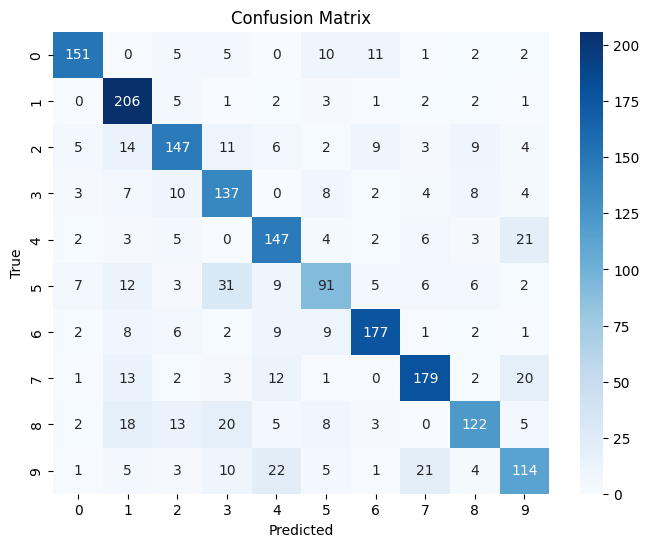

MNIST DIGIT CLASSIFICATION -- MIXTURE MODEL:
COMPONENTS: 9 11 10 9 10 8 9 9 11 11
ACCURACY ON VALIDATION: 0.796
COMPONENTS: 10 10 10 9 10 11 10 11 9 10
ACCURACY ON VALIDATION: 0.804
COMPONENTS: 8 9 11 10 11 8 8 9 11 8
ACCURACY ON VALIDATION: 0.787
COMPONENTS: 11 11 11 8 9 9 8 11 11 11
ACCURACY ON VALIDATION: 0.788
COMPONENTS: 11 11 8 10 8 10 10 11 8 8
ACCURACY ON VALIDATION: 0.7835
COMPONENTS: 11 9 10 9 11 11 8 11 9 8
ACCURACY ON VALIDATION: 0.799
COMPONENTS: 9 9 11 11 11 9 10 10 8 10
ACCURACY ON VALIDATION: 0.799
COMPONENTS: 8 8 9 8 8 11 8 10 10 10
ACCURACY ON VALIDATION: 0.798
COMPONENTS: 9 10 10 11 9 10 10 11 9 10
ACCURACY ON VALIDATION: 0.798
COMPONENTS: 11 10 10 11 11 9 10 8 9 9
ACCURACY ON VALIDATION: 0.7985
COMPONENTS: 9 11 11 10 9 10 8 10 10 11
ACCURACY ON VALIDATION: 0.7965
COMPONENTS: 11 10 11 11 9 9 11 8 9 8
ACCURACY ON VALIDATION: 0.794
COMPONENTS: 10 11 8 11 11 9 10 8 9 8
ACCURACY ON VALIDATION: 0.793
COMPONENTS: 8 8 10 11 9 8 11 9 9 9
ACCURACY ON VALIDATION: 0.792
COMPONE

In [31]:
experiment_name = "mnist"
# --- MNIST DIGIT CLASSIFICATION setup
Xtrain,Xval,num_classes,num_features = load_experiment(data_fn, experiment_name)

# -- build naive bayes model for mnist digit classification
print("MNIST DIGIT CLASSIFICATION -- NAIVE BAYES MODEL:")
nbm = NaiveBayesModel(num_classes, num_features)
nbm.train(Xtrain)
print("ACCURACY ON VALIDATION: " + str(nbm.val(Xval)))

labels = []
preds = []
for c in range(num_classes):
    labels.extend([c] * len(Xval[c]))
    preds.extend(nbm.classify(Xval[c]))
conf_matrix = confusion_matrix(labels, preds, labels=range(num_classes))
plt.figure(figsize=(8, 6))
class_names = np.arange(num_classes)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

best_accuracy = 0
best_model = None

# -- build mixture model for mnist digit classification
print("MNIST DIGIT CLASSIFICATION -- MIXTURE MODEL:")
for i in range(MAX_OUTER_ITER):
    num_mixture_components =  np.random.randint(8,12,num_classes)
    print("COMPONENTS: " + " ".join(str(i) for i in num_mixture_components))
    mm = MixtureModel(num_classes, num_features, num_mixture_components)
    mm.train(Xtrain)
    accuracy = mm.val(Xval)
    print("ACCURACY ON VALIDATION: " + str(accuracy))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = mm
    
# submit to kaggle
Xkaggle = load_data(data_fn, experiment_name, "kaggle")
save_submission("mm-{}-submission.csv".format(experiment_name), best_model.classify(Xkaggle))

Class 0 has 10 mixture components:


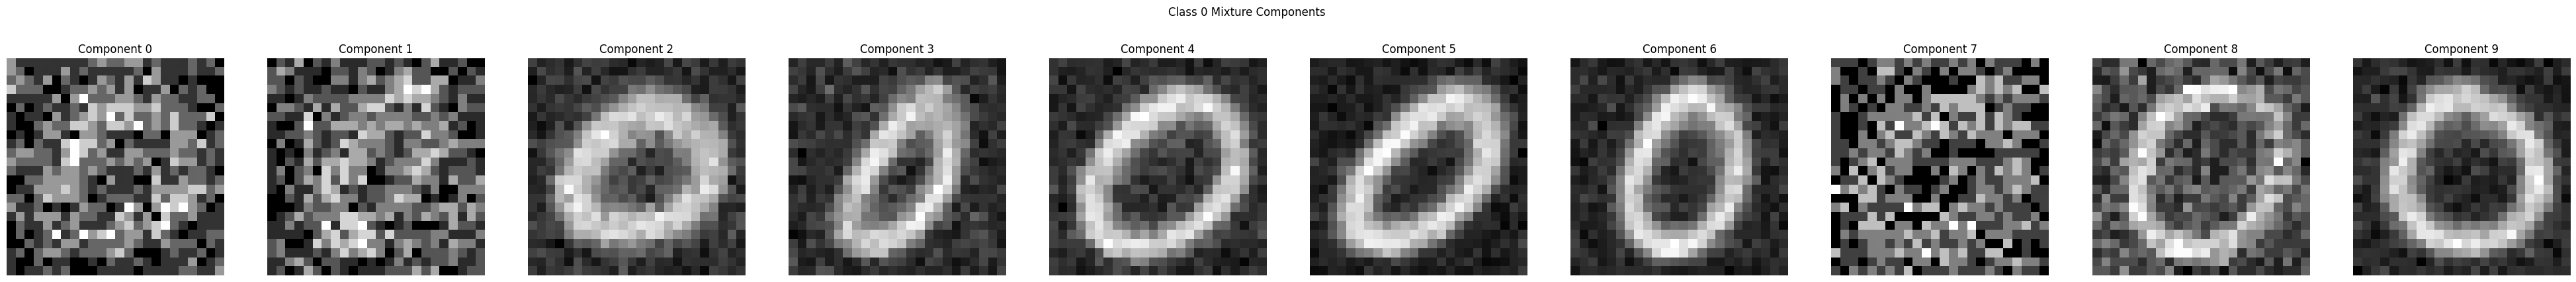

Class 1 has 10 mixture components:


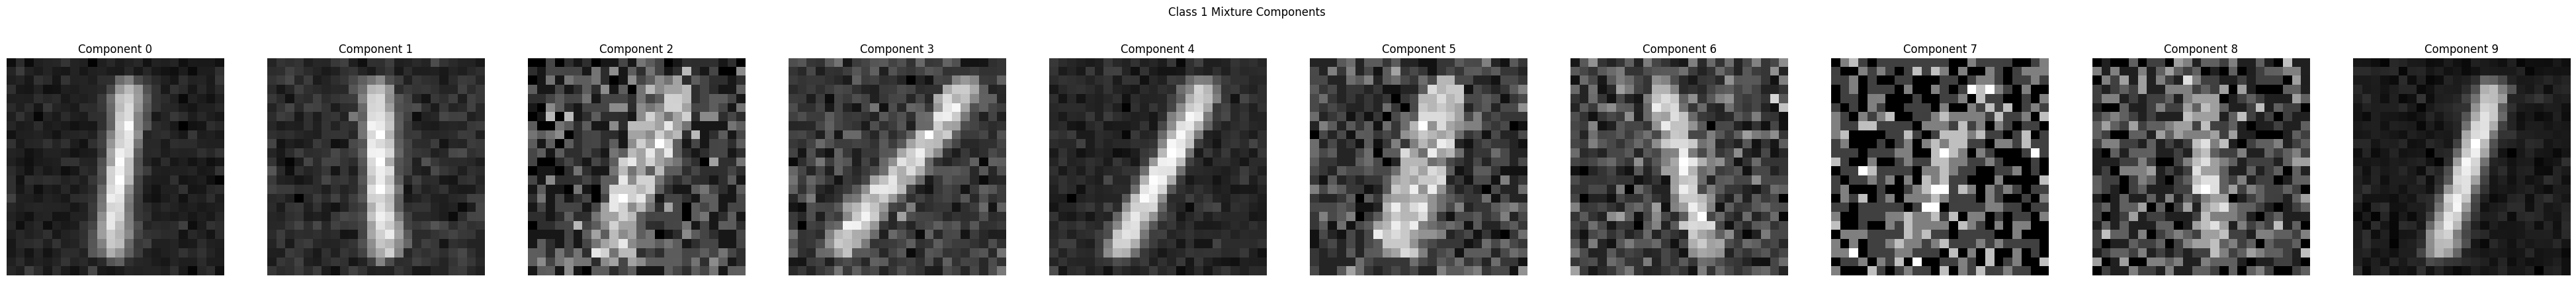

Class 2 has 10 mixture components:


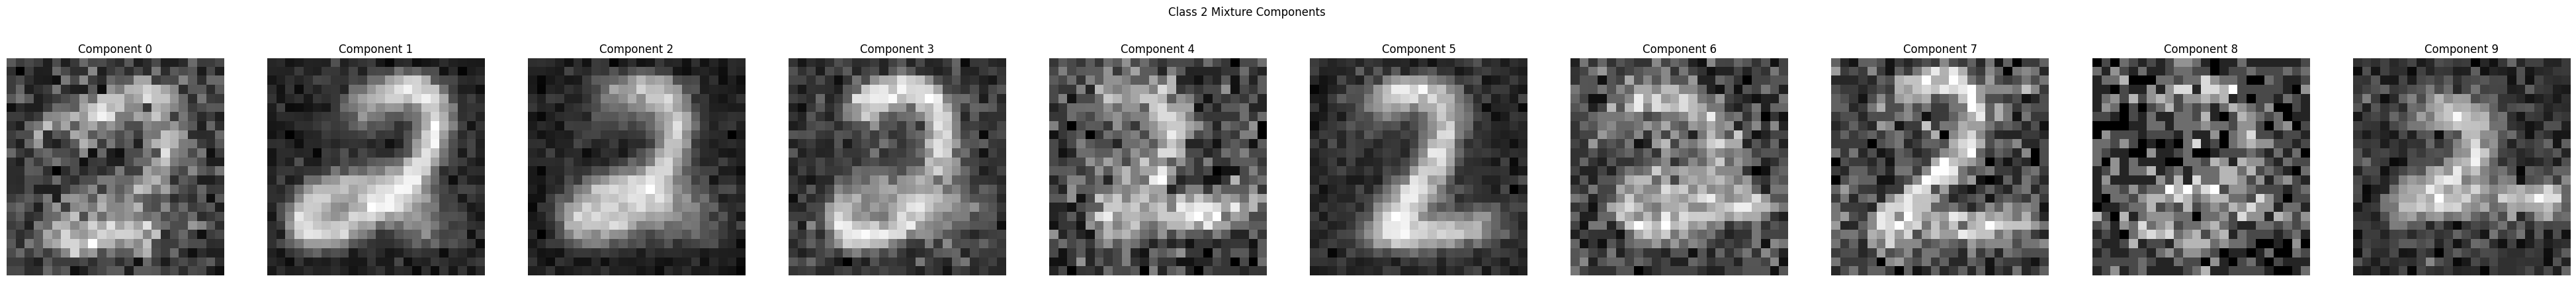

Class 3 has 9 mixture components:


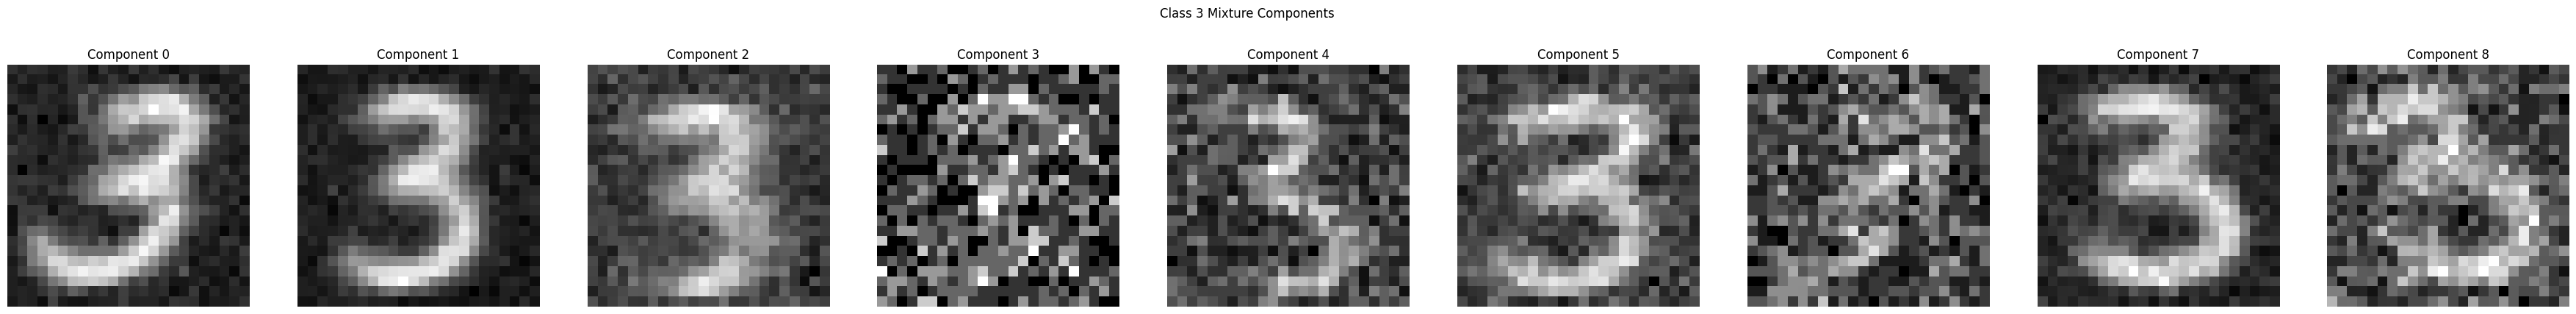

Class 4 has 10 mixture components:


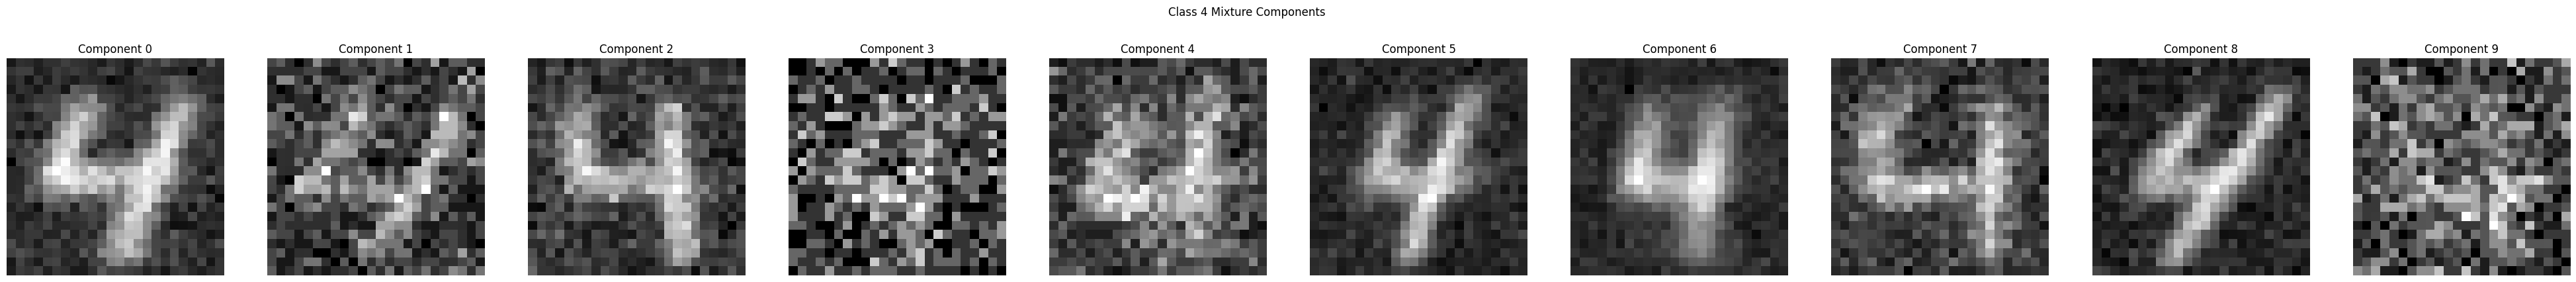

Class 5 has 11 mixture components:


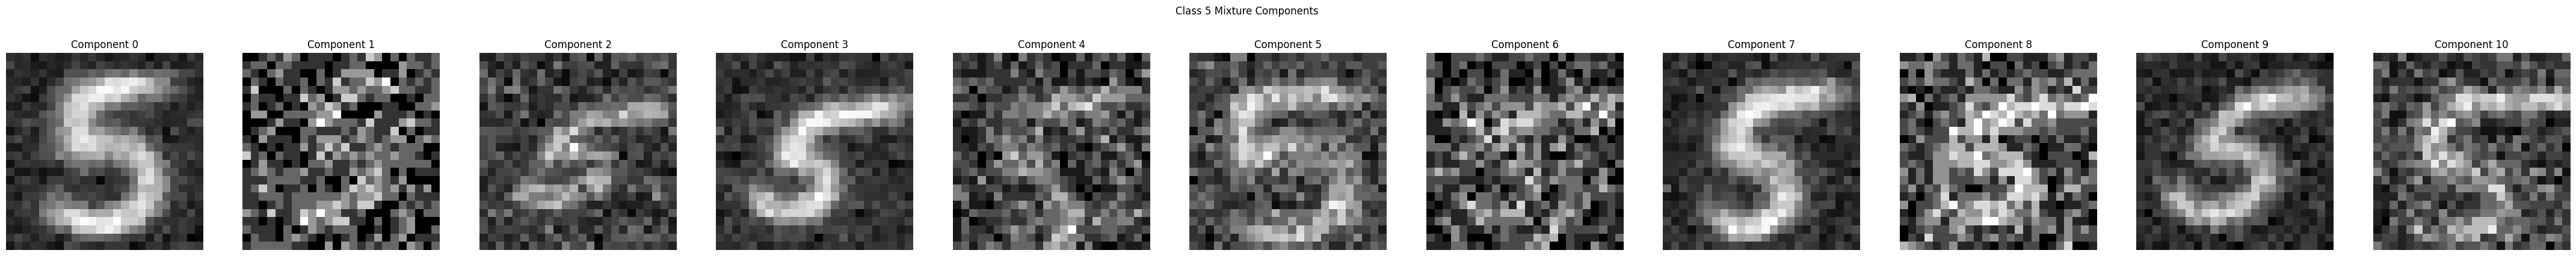

Class 6 has 10 mixture components:


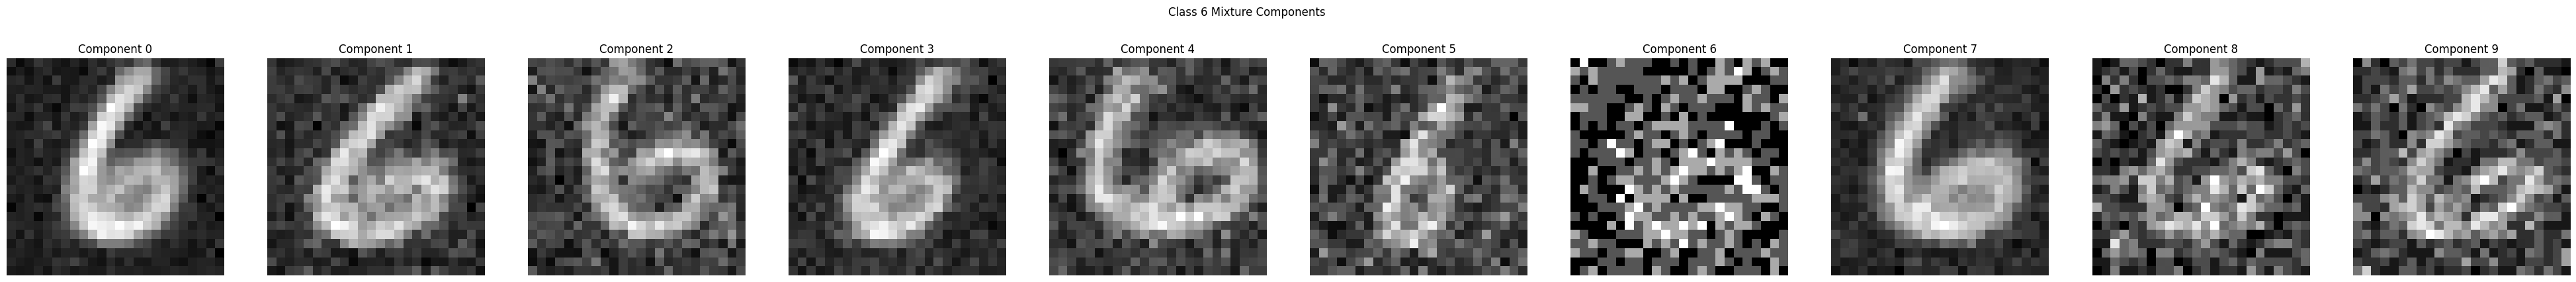

Class 7 has 11 mixture components:


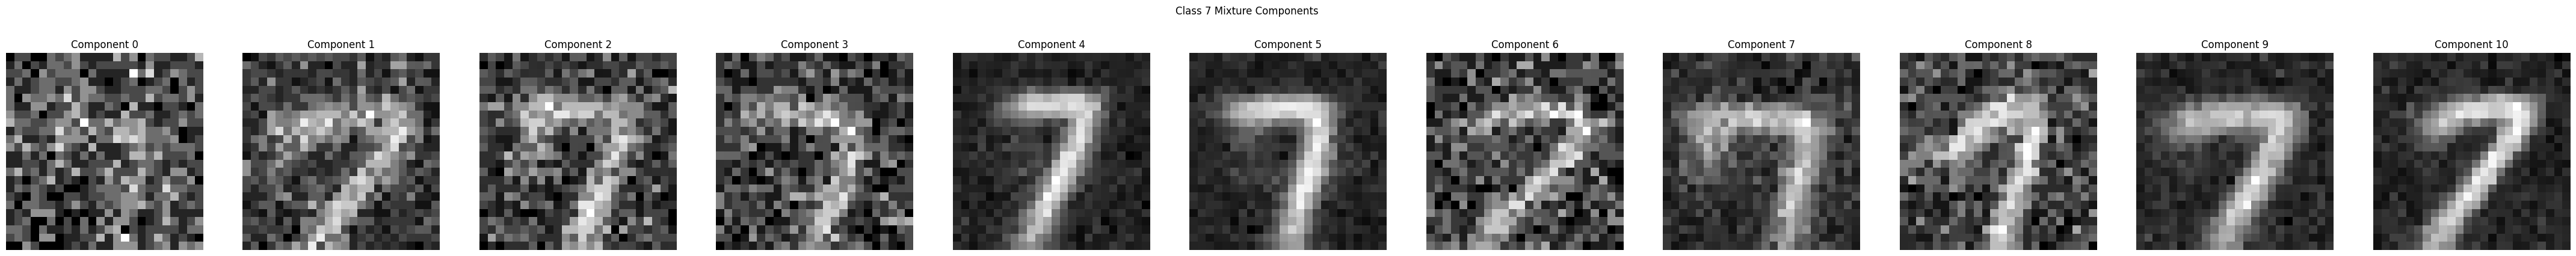

Class 8 has 9 mixture components:


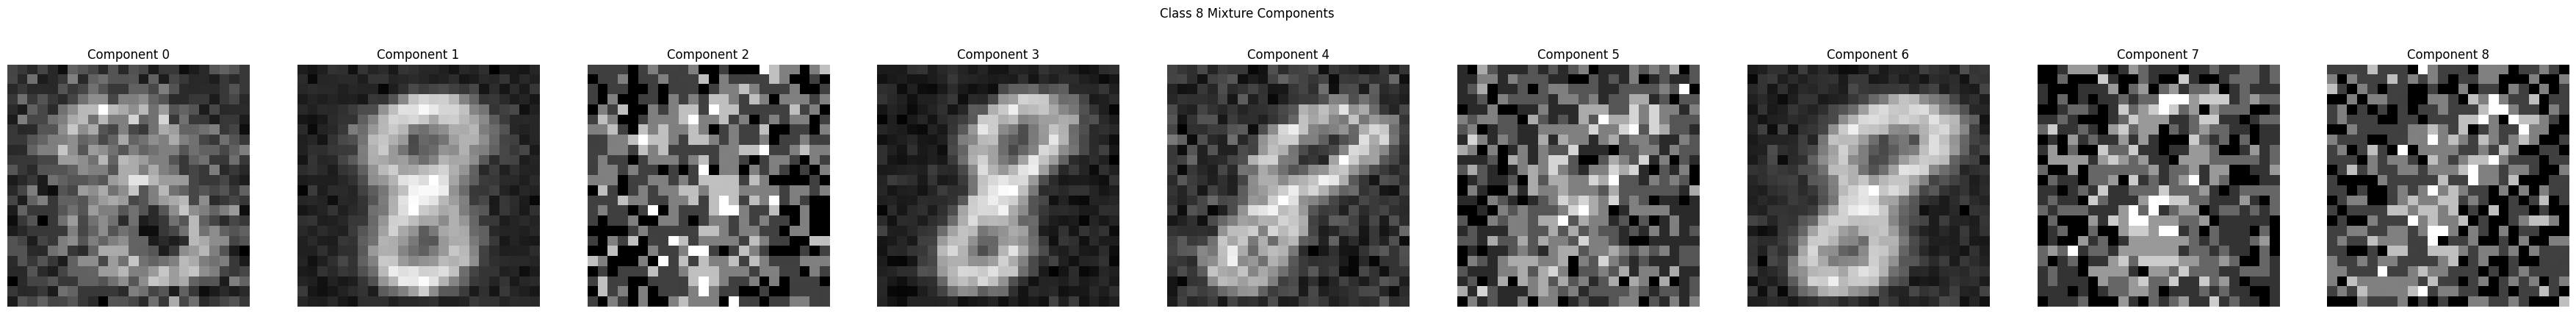

Class 9 has 10 mixture components:


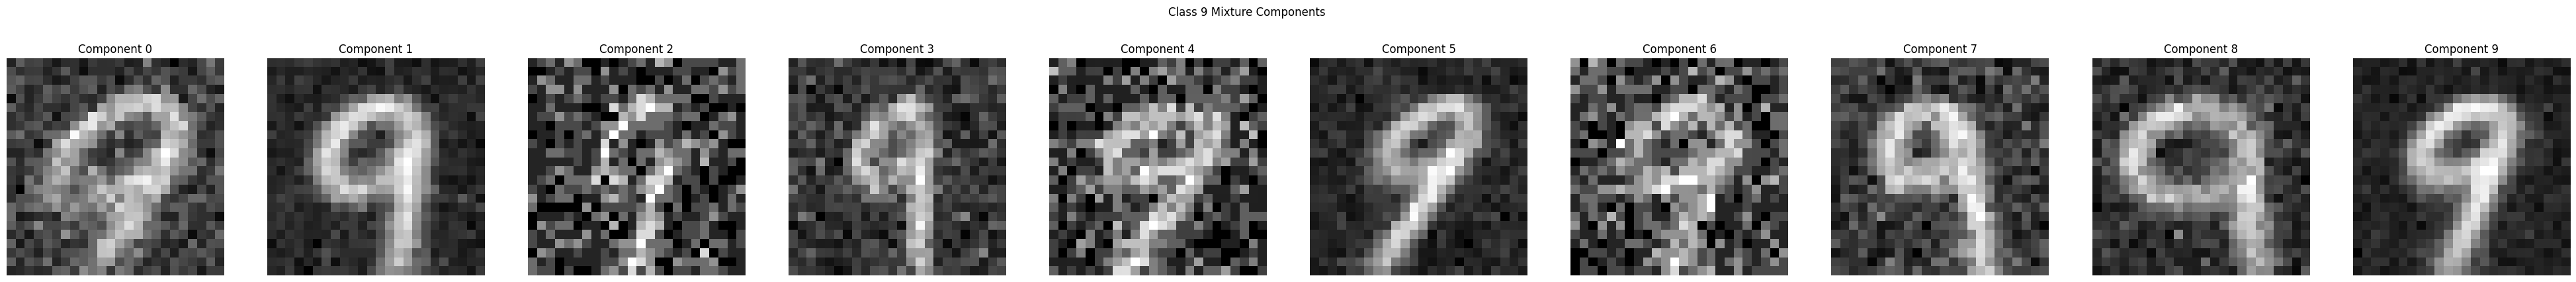

In [32]:
theta_list = best_model.params['theta']
num_classes = len(theta_list)
for i, theta in enumerate(theta_list):
    num_components = theta.shape[1]
    print(f"Class {i} has {num_components} mixture components:")
    plt.figure(figsize=(5*num_components, 5))
    for j in range(num_components):
        plt.subplot(1, num_components, j + 1)
        plt.imshow(theta[:, j].reshape(24, 24), cmap='gray')
        plt.title(f'Component {j}')
        plt.axis('off')
    plt.suptitle(f'Class {i} Mixture Components')
    plt.show()


Tuning procedure:

I originally tried to try every combination of number of mixture components for each of the 10 classes, but soon realized that that would take too long. Thus, I stuck with the starter code's randomly generated number of mixture components. I modified the starter code to store the best validation accuracy along with the best combination of number of mixture components. I realized that mixture component counts from 8 and 11 performed the best on the validation set so I changed the range of the randomly generated number of mixture components (num_mixture_components =  np.random.randint(8,12,num_classes)). 

Findings including validation errors and best hyper-parameter values:

After the 15 iterations of randomly generated number of mixture components from 8 to 11, I stored the best model. The performance or validation accuracies in this range were a lot better overall and I was able to find a better performing model from the training in this range. The best validation error achieved was 0.805 with number of mixture components (9 10 8 10 10 8 9 8 8 9).

Additional notes:

I have displayed the components for the MNIST dataset using the best model. A potential improvement to my method would be to have a different range for each class. It is not necessarily true that the optimal range for number of mixture components each class is the same. One interesting thing to note is that when I narrowed the range too small, there waas not as much improvement to the validation scores. I was probably narrowing down into a non-optimal number of mixture components. Thus, in the case of this small experimentation, it is better to keep the range bigger and utilize randomness to find varying validation accuracies. Some of which will be more preferable. For more extensive exxperimentation, I would try some algorithm to narrow down the range for each class.